In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import numpy as np
import datetime as dt
import hvplot.pandas
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import linregress
import holoviews as hv
hv.extension('bokeh')
from bokeh.models import NumeralTickFormatter
from prophet import Prophet
from neuralprophet import NeuralProphet
import pmdarima as pm

In [2]:
df2 = pd.read_csv('Resources/credit_card_transactions.csv')
df2.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [3]:
df2["trans_date_trans_time"] = pd.to_datetime(df2["trans_date_trans_time"], utc=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   Unnamed: 0             1296675 non-null  int64              
 1   trans_date_trans_time  1296675 non-null  datetime64[ns, UTC]
 2   cc_num                 1296675 non-null  int64              
 3   merchant               1296675 non-null  object             
 4   category               1296675 non-null  object             
 5   amt                    1296675 non-null  float64            
 6   first                  1296675 non-null  object             
 7   last                   1296675 non-null  object             
 8   gender                 1296675 non-null  object             
 9   street                 1296675 non-null  object             
 10  city                   1296675 non-null  object             
 11  state                  1

In [4]:
data = df2
df2 = data.copy()
df2['trans_date'] = pd.to_datetime(df2['trans_date_trans_time'], utc=True).dt.date
df2['trans_year'] = pd.to_datetime(df2['trans_date_trans_time'], utc=True).dt.year
df2['trans_month'] = pd.to_datetime(df2['trans_date_trans_time'], utc=True).dt.month
df2['trans_day'] = pd.to_datetime(df2['trans_date_trans_time'], utc=True).dt.day
df2.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,trans_date,trans_year,trans_month,trans_day
0,0,2019-01-01 00:00:18+00:00,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0,2019-01-01,2019,1,1
1,1,2019-01-01 00:00:44+00:00,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN,2019-01-01,2019,1,1
2,2,2019-01-01 00:00:51+00:00,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0,2019-01-01,2019,1,1
3,3,2019-01-01 00:01:16+00:00,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN,2019-01-01,2019,1,1
4,4,2019-01-01 00:03:06+00:00,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0,2019-01-01,2019,1,1


In [5]:
# Ensure 'dob' is a datetime object
df2['dob'] = pd.to_datetime(df2['dob'], errors='coerce')

# Calculate the 'Age' column
df2['age'] = df2['trans_year'] - df2['dob'].dt.year

# Define age groups based on the ranges provided
def age_description(age):
    if age < 18:
        return 'Age: 18 & Under / Youth / Teens'
    elif 19 <= age <= 28:
        return 'Age: 19-28 / Young Adults'
    elif 29 <= age <= 38:
        return 'Age: 29-38 / Early Career / Early Adults'
    elif 39 <= age <= 48:
        return 'Age: 39-48 / Mid-Life Professionals / Experienced Adults'
    elif 49 <= age <= 58:
        return 'Age: 49-58 / Seasoned Adults / Mature Professionals'
    elif 59 <= age <= 68:
        return 'Age: 59-68 / Pre-Retirement / Early Retirees'
    elif 69 <= age <= 78:
        return 'Age: 69-78 / Active Retirees / Golden Years'
    else:
        return 'Age: 79 & Older / Seniors / Elderly'

# Step 4: Create the 'Age Description' column
df2['age_description'] = df2['age'].apply(age_description)

# View the final dataframe with the new columns
df2[['age', 'age_description']].head()

,age,age_description
0,31,Age: 29-38 / Early Career / Early Adults
1,41,Age: 39-48 / Mid-Life Professionals / Experien...
2,57,Age: 49-58 / Seasoned Adults / Mature Professi...
3,52,Age: 49-58 / Seasoned Adults / Mature Professi...
4,33,Age: 29-38 / Early Career / Early Adults


In [6]:
# Count the number of people in each age group
age_group_counts = df2['age_description'].value_counts()

# Display the counts
print(age_group_counts)

age_description
Age: 29-38 / Early Career / Early Adults                    300943
Age: 39-48 / Mid-Life Professionals / Experienced Adults    300161
Age: 49-58 / Seasoned Adults / Mature Professionals         200411
Age: 19-28 / Young Adults                                   181766
Age: 59-68 / Pre-Retirement / Early Retirees                143773
Age: 69-78 / Active Retirees / Golden Years                  78761
Age: 79 & Older / Seniors / Elderly                          77430
Age: 18 & Under / Youth / Teens                              13430
Name: count, dtype: int64


In [7]:
# Group data by 'age_description' and 'is_fraud'
fraud_by_age = df2.groupby('age_description')['is_fraud'].sum().reset_index()

# Rename the columns for clarity
fraud_by_age.columns = ['Age Group', 'Fraudulent Transactions']

# Calculate the total number of transactions for each age group to determine the percentage of fraudulent transactions
total_transactions_by_age = df2.groupby('age_description')['is_fraud'].count().reset_index()
total_transactions_by_age.columns = ['Age Group', 'Total Transactions']

# Merge the dataframes to calculate the percentage of fraudulent transactions
fraud_comparison = pd.merge(fraud_by_age, total_transactions_by_age, on='Age Group')
fraud_comparison['Fraud Percentage'] = (fraud_comparison['Fraudulent Transactions'] / fraud_comparison['Total Transactions']) * 100

# Create a bar chart using plotly for fraudulent transactions by age group
fig = px.bar(
    fraud_comparison, 
    x='Age Group', 
    y='Fraudulent Transactions', 
    title="Total Fraudulent Transactions by Age Group",
    labels={'Fraudulent Transactions': 'Fraud Cases', 'Age Group': 'Age Group'},
    height=500, width=800
)

# Display the chart
fig.show()

# Pie chart for the percentage of fraudulent transactions by age group
fig_pie = px.pie(
    fraud_comparison, 
    names='Age Group', 
    values='Fraud Percentage', 
    title="Percentage of Fraudulent Transactions by Age Group",
    height=500, width=800,
    hole=0.4
)

# Update the layout to center the legend vertically on the right margin and keep the pie chart size
fig_pie.update_traces(
    pull=[0.05 for _ in range(len(fraud_comparison))]  # Optional: slight "pull" effect for better clarity
)

# Adjust pie chart size by limiting the domain to avoid growth
fig_pie.update_traces(domain=dict(x=[0.0, 0.65]))  # Adjust the domain for pie chart width

fig_pie.update_layout(
    legend=dict(
        orientation="v",  # Keep the legend vertical
        yanchor="middle",  # Align the legend to the middle vertically
        y=0.5,  # Vertical center of the legend relative to the chart
        xanchor="left",  # Align the legend to the right of the chart
        x=0.9  # Position slightly to the right of the pie chart
    ),
    title={
        'text': 'Percentage of Fraudulent Transactions by Age Group',
        'y':0.90,  # Position the title closer to the top
        'x':0.5,  # Center the title horizontally
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin=dict(t=50, l=50, r=0)  # Adjust margins for proper spacing
)

# Display the updated pie chart
fig_pie.show()

In [8]:
# Filter for fraudulent transactions
fraud_data = df2[df2['is_fraud'] == 1]

# Group the data by 'category' and sum the 'amt' for each category
fraud_by_category = fraud_data.groupby('category')['amt'].sum().reset_index()

# Calculate the total amount for each category (including non-fraudulent transactions)
total_by_category = df2.groupby('category')['amt'].sum().reset_index()

# Merge both dataframes to calculate the percentage of fraud for each category
fraud_percentage_by_category = pd.merge(fraud_by_category, total_by_category, on='category', suffixes=('_fraud', '_total'))

# Calculate the percentage of fraudulent transactions for each category
fraud_percentage_by_category['fraud_percentage'] = (fraud_percentage_by_category['amt_fraud'] / fraud_percentage_by_category['amt_total']) * 100

# Create a pie chart using plotly for the percentage of fraudulent transactions by category
fig = px.pie(
    fraud_percentage_by_category, 
    values='fraud_percentage', 
    names='category', 
    title="Percentage of Fraudulent Transactions by Category",
    height=500, width=800, hole=0.40
)

# Break out slices with a border and update the hover template
fig.update_traces(
    pull=[0.05 for _ in fraud_percentage_by_category['category']],  # Slightly pull out each slice
    textposition='inside', 
    textinfo='percent+label',
    hovertemplate='Category: %{label}<br>Fraud Percentage: %{value:.1f}%'  # Show percentage on hover
)

# Match the layout and style to Cell 1
fig.update_layout(
    title={
        'text': "Percentage of Fraudulent Transactions by Category",
        'y':0.95,  # Position the title closer to the top
        'x':0.5,   # Center the title horizontally
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend=dict(
        orientation="v",  # Keep the legend vertical
        yanchor="middle",  # Align the legend to the middle vertically
        y=0.5,  # Vertical center of the legend relative to the chart
        xanchor="left",  # Align the legend to the right of the chart
        x=0.7  # Position slightly to the right of the pie chart
    ),
    margin=dict(t=50, l=50, r=0),  # Adjust margins to match Cell 1
    showlegend=True  # Ensure the legend is displayed
)

# Adjust pie chart size by limiting the domain to avoid growth (optional step)
fig.update_traces(domain=dict(x=[0.0, 0.65]))

# Display the pie chart
fig.show()

In [9]:
# Filter for fraudulent transactions and group by date, counting the number of fraud charges
fraud_df = df2[df2['is_fraud'] == 1].groupby('trans_date')['is_fraud'].count().reset_index()

# Rename columns for clarity
fraud_df.columns = ['date', 'fraud_charge_count']

# Display the resulting DataFrame
fraud_df



,date,fraud_charge_count
0,2019-01-02,7
1,2019-01-03,12
2,2019-01-04,13
3,2019-01-05,13
4,2019-01-06,2
...,...,...
499,2020-06-17,35
500,2020-06-18,39
501,2020-06-19,25
502,2020-06-20,26


In [10]:
# Rename columns for Prophet
fraud_df.columns=['ds','y']
fraud_df.tail()

,ds,y
499,2020-06-17,35
500,2020-06-18,39
501,2020-06-19,25
502,2020-06-20,26
503,2020-06-21,7


In [11]:
# Initialize a Prophet model
model = Prophet()

# Fit the model to the data
model.fit(fraud_df)

# Create a DataFrame for future dates to forecast
future = model.make_future_dataframe(periods=365)  # Adjust the periods as needed

# Make predictions
fraud_forecast = model.predict(future)

# Display the forecast
display(fraud_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
display(fraud_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


20:42:39 - cmdstanpy - INFO - Chain [1] start processing
20:42:39 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2019-01-02,12.982760,2.151075,23.993927
1,2019-01-03,15.113664,3.912963,26.728015
2,2019-01-04,15.699244,4.255368,27.071044
3,2019-01-05,17.770221,6.155748,29.278862
4,2019-01-06,17.142521,5.308027,28.921197


,ds,yhat,yhat_lower,yhat_upper
864,2021-06-17,12.653994,1.168636,24.930786
865,2021-06-18,13.239610,1.227775,25.282468
866,2021-06-19,15.310624,2.644683,25.958445
867,2021-06-20,14.682961,2.859689,26.155453
868,2021-06-21,14.446993,2.558218,25.144012


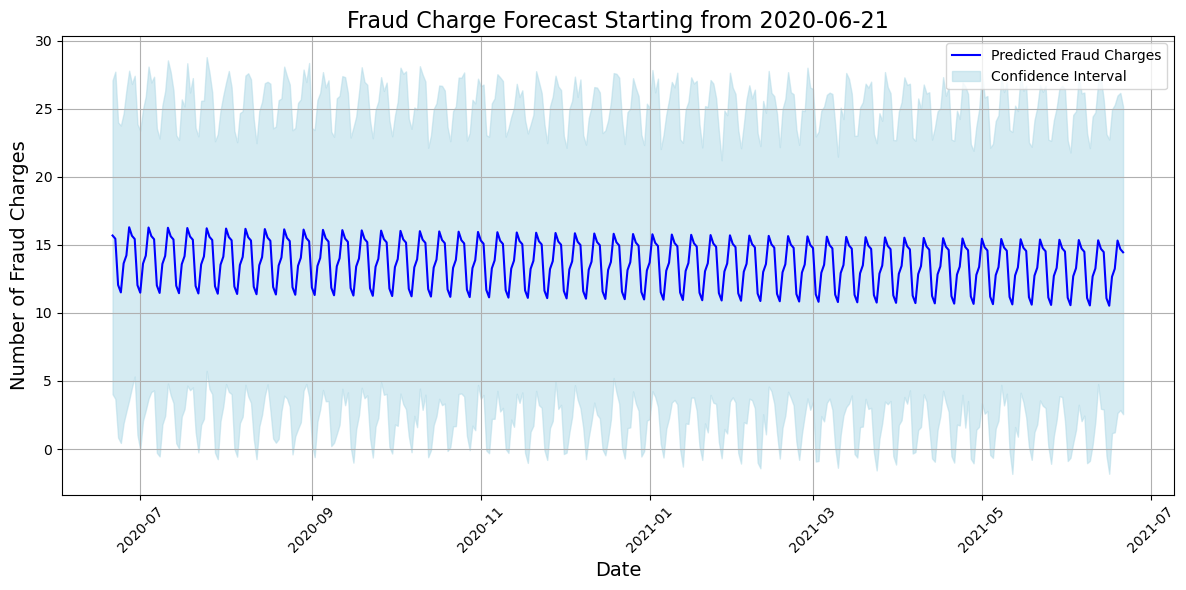

In [12]:
# Filter the forecast to start from 2020-06-21
start_date = '2020-06-21'
fraud_forecast_filtered = fraud_forecast[fraud_forecast['ds'] >= start_date]

# Plotting the forecast
plt.figure(figsize=(12, 6))

# Plot the forecasted values
plt.plot(fraud_forecast_filtered['ds'], fraud_forecast_filtered['yhat'], label='Predicted Fraud Charges', color='blue')

# Plot the confidence intervals
plt.fill_between(fraud_forecast_filtered['ds'], 
                 fraud_forecast_filtered['yhat_lower'], 
                 fraud_forecast_filtered['yhat_upper'], 
                 color='lightblue', 
                 alpha=0.5, 
                 label='Confidence Interval')

# Add labels and title
plt.title('Fraud Charge Forecast Starting from 2020-06-21', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Fraud Charges', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [13]:
# Ensure the 'ds' column in both DataFrames is of datetime type
fraud_forecast['ds'] = pd.to_datetime(fraud_forecast['ds'])
fraud_df['ds'] = pd.to_datetime(fraud_df['ds'])

# Merge the actual and forecast data
combined_df = pd.merge(
    fraud_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    fraud_df[['ds', 'y']],
    on='ds',
    how='left'
)

# Rename the actual fraud column for clarity
combined_df.rename(columns={'y': 'actual_fraud_count'}, inplace=True)

# Plotting with hvplot
plot_actual = combined_df.hvplot.line(x='ds', y='actual_fraud_count', label='Actual Fraud Charges', color='blue', line_width=2)
plot_forecast = combined_df.hvplot.line(x='ds', y='yhat', label='Forecasted Fraud Charges', color='orange', line_width=2)
plot_uncertainty = combined_df.hvplot.area(x='ds', y='yhat_lower', y2='yhat_upper', label='Uncertainty Interval', color='orange', alpha=0.3)

# Combine all plots
final_plot = plot_actual * plot_forecast * plot_uncertainty

# Customize plot
final_plot.opts(
    title='Fraud Charge Forecasting',
    xlabel='Date',
    ylabel='Number of Fraud Charges',
    legend_position='top_left',
    width=1000, 
    height=600   
)

# Show the plot
final_plot


:Overlay
   .Curve.Actual_Fraud_Charges     :Curve   [ds]   (actual_fraud_count)
   .Curve.Forecasted_Fraud_Charges :Curve   [ds]   (yhat)
   .Area.Uncertainty_Interval      :Area   [ds]   (yhat_lower,yhat_upper)

In [14]:
fraud_df.rename(columns={'date': 'ds', 'fraud_charge_count': 'y'}, inplace=True)

fraud_df.head()

,ds,y
0,2019-01-02,7
1,2019-01-03,12
2,2019-01-04,13
3,2019-01-05,13
4,2019-01-06,2


In [15]:
# Initialize NeuralProphet model
model = NeuralProphet()

# Fit the model
model.fit(fraud_df, freq='D')

# Forecasting the next 30 days
future = model.make_future_dataframe(fraud_df, periods=365)
forecast = model.predict(future)

# Display forecast
print(forecast[['ds', 'yhat1']].tail())

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/dev/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.04% of the data.
WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/dev/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/dev/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (16) is too small than the required number                     for the learning rate finder (219). The results might not be optimal.


Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/dev/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/dev/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/dev/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.04% of the data.
WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/dev/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/dev/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_d

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


            ds      yhat1
360 2021-06-17  22.223883
361 2021-06-18  23.778435
362 2021-06-19  25.833622
363 2021-06-20  25.717293
364 2021-06-21  23.726173


In [16]:
fraud_df

,ds,y
0,2019-01-02,7
1,2019-01-03,12
2,2019-01-04,13
3,2019-01-05,13
4,2019-01-06,2
...,...,...
499,2020-06-17,35
500,2020-06-18,39
501,2020-06-19,25
502,2020-06-20,26


In [32]:
import hvplot.pandas  # Required to use hvPlot with pandas DataFrames

# Combine the forecast with the original data for visualization
forecast_df = forecast[['ds', 'yhat1']]
forecast_df.columns = ['Date', 'Forecast']
fraud_df.columns = ['Date', 'Actual']

# Merge the actual data with forecasted data for easier comparison
fraudchargecountforcast = pd.merge(fraud_df, forecast_df, on='Date', how='outer')

# Plot the data using hvPlot
fraudchargecountforcast.hvplot(x='Date', y=['Actual', 'Forecast'], 
                   ylabel='Fraud Charge Count', 
                   xlabel='Date', 
                   title='Fraud Charge Count Forecast', 
                   width=800, 
                   height=400)


KeyError: "None of [Index(['ds', 'yhat1'], dtype='object')] are in the [index]"

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


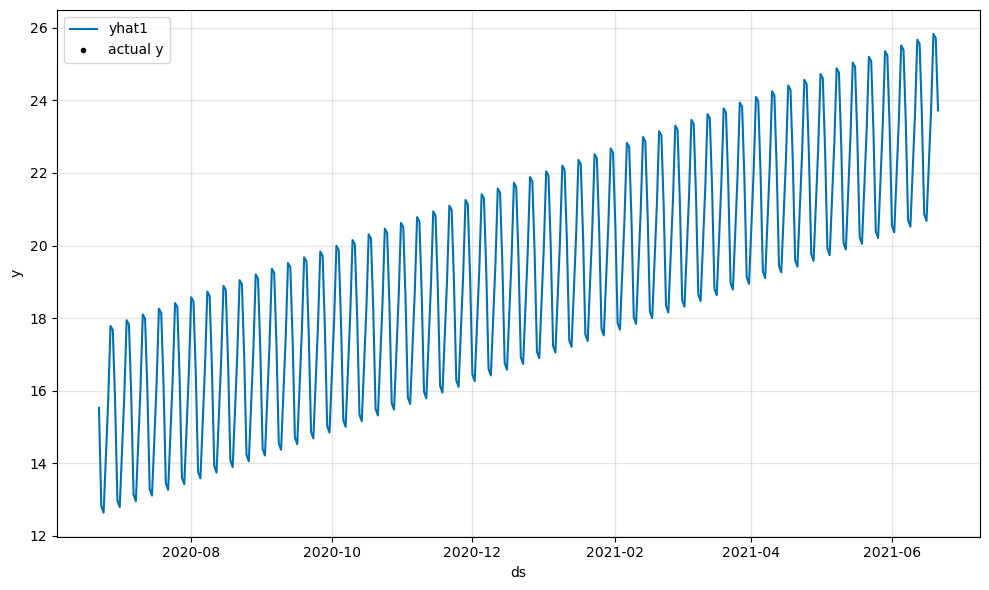

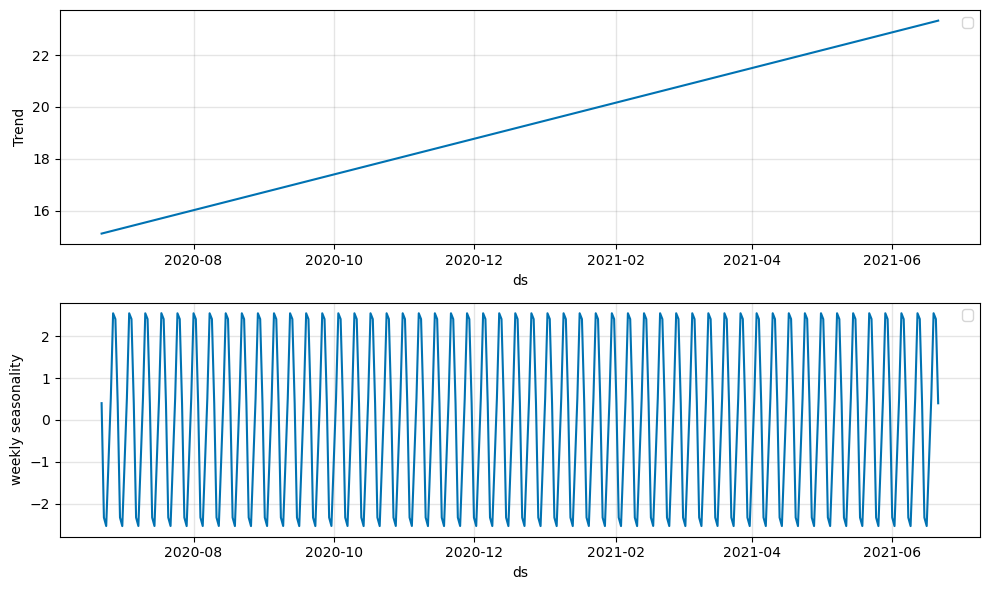

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Use matplotlib-based plotting functions
fig_forecast = model.plot(forecast, plotting_backend="matplotlib")
fig_components = model.plot_components(forecast, plotting_backend="matplotlib")


In [19]:
fraud_df

,Date,Actual
0,2019-01-02,7
1,2019-01-03,12
2,2019-01-04,13
3,2019-01-05,13
4,2019-01-06,2
...,...,...
499,2020-06-17,35
500,2020-06-18,39
501,2020-06-19,25
502,2020-06-20,26


In [20]:
fraud_df.set_index('Date', inplace=True)

In [21]:

# Fit the ARIMA model automatically
model = pm.auto_arima(fraud_df['Actual'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Forecast the next 30 days
n_periods = 365
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Create a DataFrame for the forecasted values and dates
forecast_dates = pd.date_range(fraud_df.index[-1] + pd.Timedelta(days=1), periods=n_periods)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast, 
                            'Lower Conf Int': conf_int[:, 0], 'Upper Conf Int': conf_int[:, 1]})

# Reset index for merging with hvplot
fraud_df.reset_index(inplace=True)
fraud_df.columns = ['Date', 'Actual']


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4319.435, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3785.528, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3996.376, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3776.824, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3725.309, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3718.628, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3694.038, Time=0.04 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=3613.167, Time=0.14 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3612.022, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3613.756, Time=0.06 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3613.489, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3612.7

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=3614.797, Time=0.36 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 1.806 seconds


In [22]:
# Merge the actual data with forecasted data for easier comparison
combined_df = pd.concat([fraud_df, forecast_df], ignore_index=True)

# Plot the data using hvPlot
plot = combined_df.hvplot(x='Date', y=['Actual', 'Forecast'], ylabel='Fraud Charge Count', xlabel='Date', 
                          title='Fraud Charge Count Forecast', width=800, height=400)

# Add confidence intervals to the plot
ci_plot = forecast_df.hvplot.area(x='Date', y='Lower Conf Int', y2='Upper Conf Int', alpha=0.3, color='gray')
(plot * ci_plot).opts(legend_position='top')


:Overlay
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Area.I      :Area   [Date]   (Lower Conf Int,Upper Conf Int)

In [23]:
# Convert 'trans_date' to datetime if it isn't already
df2['trans_date'] = pd.to_datetime(df2['trans_date'])

# Filter for fraudulent transactions
fraud_df = df2[df2['is_fraud'] == 1]

# Group by week and count the number of fraud charges
fraud_df_weekly = fraud_df.resample('W-Mon', on='trans_date').size().reset_index(name='fraud_charge_count')

# Rename columns for clarity
fraud_df_weekly.columns = ['date', 'fraud_charge_count']

# Display the resulting DataFrame
print(fraud_df_weekly.head())


        date  fraud_charge_count
0 2019-01-07                  51
1 2019-01-14                 158
2 2019-01-21                 155
3 2019-01-28                  67
4 2019-02-04                 149


In [24]:

# Rename columns for Prophet
fraud_df_weekly.columns=['ds','y']
fraud_df_weekly.tail()


,ds,y
72,2020-05-25,131
73,2020-06-01,82
74,2020-06-08,113
75,2020-06-15,74
76,2020-06-22,142


In [25]:
# Set up and fit the Prophet model
modelweek = Prophet()
modelweek.fit(fraud_df_weekly)

# Create a DataFrame for future dates you want to forecast
future2 = modelweek.make_future_dataframe(periods=104)

# Forecast the future values
fraud_forecast_weekly = modelweek.predict(future2)

# Display the forecast
print(fraud_forecast_weekly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


20:43:09 - cmdstanpy - INFO - Chain [1] start processing


20:43:09 - cmdstanpy - INFO - Chain [1] done processing


          ds        yhat  yhat_lower  yhat_upper
0 2019-01-07  101.871922   59.962050  141.578083
1 2019-01-14  101.756289   61.678934  140.854536
2 2019-01-21  101.640656   60.515855  142.340047
3 2019-01-28  101.525023   58.753521  143.183519
4 2019-02-04  101.409389   61.755806  143.067015


In [26]:
# Ensure the 'ds' column in both DataFrames is of datetime type
fraud_forecast_weekly['ds'] = pd.to_datetime(fraud_forecast_weekly['ds'])
fraud_df_weekly['ds'] = pd.to_datetime(fraud_df_weekly['ds'])

# Merge the actual and forecast data
combined_df_weekly = pd.merge(
    fraud_forecast_weekly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    fraud_df_weekly[['ds', 'y']],
    on='ds',
    how='left'
)

# Rename the actual fraud column for clarity
combined_df_weekly.rename(columns={'y': 'actual_fraud_count'}, inplace=True)

# Plotting with hvplot
plot_actual2 = combined_df_weekly.hvplot.line(x='ds', y='actual_fraud_count', label='Actual Fraud Charges', color='blue', line_width=2)
plot_forecast2 = combined_df_weekly.hvplot.line(x='ds', y='yhat', label='Forecasted Fraud Charges', color='orange', line_width=2)
plot_uncertainty2 = combined_df_weekly.hvplot.area(x='ds', y='yhat_lower', y2='yhat_upper', label='Uncertainty Interval', color='orange', alpha=0.3)

# Combine all plots
final_plot_weekly = plot_actual2 * plot_forecast2 * plot_uncertainty2

# Customize plot
final_plot_weekly.opts(
    title='Fraud Charge Forecasting',
    xlabel='Date',
    ylabel='Number of Fraud Charges',
    legend_position='top_left',
    width=1000, 
    height=600   
)

# Show the plot
final_plot_weekly


:Overlay
   .Curve.Actual_Fraud_Charges     :Curve   [ds]   (actual_fraud_count)
   .Curve.Forecasted_Fraud_Charges :Curve   [ds]   (yhat)
   .Area.Uncertainty_Interval      :Area   [ds]   (yhat_lower,yhat_upper)

In [27]:
import pandas as pd
import hvplot.pandas  # Ensure hvplot is imported

# Ensure the 'ds' column in both DataFrames is of datetime type
fraud_forecast_weekly['ds'] = pd.to_datetime(fraud_forecast_weekly['ds'])
fraud_df_weekly['ds'] = pd.to_datetime(fraud_df_weekly['ds'])

# Merge the actual and forecast data
combined_df_weekly = pd.merge(
    fraud_forecast_weekly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    fraud_df_weekly[['ds', 'y']],
    on='ds',
    how='left'
)

# Rename the actual fraud column for clarity
combined_df_weekly.rename(columns={'y': 'actual_fraud_count'}, inplace=True)

# Filter combined_df_weekly for dates starting from 2020
combined_df_weekly = combined_df_weekly[combined_df_weekly['ds'] >= '2020-01-01']

# Plotting with hvplot
plot_actual2 = combined_df_weekly.hvplot.line(
    x='ds', 
    y='actual_fraud_count', 
    label='Actual Fraud Charges', 
    color='blue', 
    line_width=2
)
plot_forecast2 = combined_df_weekly.hvplot.line(
    x='ds', 
    y='yhat', 
    label='Forecasted Fraud Charges', 
    color='orange', 
    line_width=2
)
plot_uncertainty2 = combined_df_weekly.hvplot.area(
    x='ds', 
    y='yhat_lower', 
    y2='yhat_upper', 
    label='Uncertainty Interval', 
    color='orange', 
    alpha=0.3
)

# Combine all plots
final_plot_weekly = plot_actual2 * plot_forecast2 * plot_uncertainty2

# Customize plot
final_plot_weekly.opts(
    title='Fraud Charge Forecasting (From 2020 Onwards)',
    xlabel='Date',
    ylabel='Number of Fraud Charges',
    legend_position='top_left',
    width=1000, 
    height=600   
)

# Show the plot
final_plot_weekly


:Overlay
   .Curve.Actual_Fraud_Charges     :Curve   [ds]   (actual_fraud_count)
   .Curve.Forecasted_Fraud_Charges :Curve   [ds]   (yhat)
   .Area.Uncertainty_Interval      :Area   [ds]   (yhat_lower,yhat_upper)

In [28]:
# Convert 'trans_date' to datetime if it isn't already
df2['trans_date'] = pd.to_datetime(df2['trans_date'])

# Filter for fraudulent transactions
fraud_df = df2[df2['is_fraud'] == 1]

# Group by month and count the number of fraud charges
fraud_df_monthly = fraud_df.resample('ME', on='trans_date').size().reset_index(name='fraud_charge_count')

# Rename columns for clarity
fraud_df_monthly.columns = ['date', 'fraud_charge_count']

# Display the resulting DataFrame
print(fraud_df_monthly.head())


        date  fraud_charge_count
0 2019-01-31                 506
1 2019-02-28                 517
2 2019-03-31                 494
3 2019-04-30                 376
4 2019-05-31                 408


In [29]:
# Rename columns for Prophet
fraud_df_monthly.columns=['ds','y']
fraud_df_monthly.tail()

,ds,y
13,2020-02-29,336
14,2020-03-31,444
15,2020-04-30,302
16,2020-05-31,527
17,2020-06-30,334


In [30]:
# Set up and fit the Prophet model
modelmonth = Prophet()
modelmonth.fit(fraud_df_monthly)

# Create a DataFrame for future dates you want to forecast
future3 = modelmonth.make_future_dataframe(periods=12)

# Forecast the future values
fraud_forecast_monthly = modelmonth.predict(future3)

# Display the forecast
print(fraud_forecast_monthly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

20:43:09 - cmdstanpy - INFO - Chain [1] start processing
20:43:09 - cmdstanpy - INFO - Chain [1] done processing


           ds        yhat  yhat_lower  yhat_upper
25 2020-07-08  382.381386  280.637396  474.395486
26 2020-07-09  382.251701  288.574943  479.791263
27 2020-07-10  382.122017  285.217573  478.384676
28 2020-07-11  381.992332  281.889743  482.069029
29 2020-07-12  381.862647  284.691265  485.586519


In [31]:
# Ensure the 'ds' column in both DataFrames is of datetime type
fraud_forecast_monthly['ds'] = pd.to_datetime(fraud_forecast_monthly['ds'])
fraud_df_monthly['ds'] = pd.to_datetime(fraud_df_monthly['ds'])

# Merge the actual and forecast data
combined_df_monthly = pd.merge(
    fraud_forecast_monthly[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    fraud_df_monthly[['ds', 'y']],
    on='ds',
    how='left'
)

# Rename the actual fraud column for clarity
combined_df_monthly.rename(columns={'y': 'actual_fraud_count'}, inplace=True)


# Plotting with hvplot
plot_actual3 = combined_df_monthly.hvplot.line(x='ds', y='actual_fraud_count', label='Actual Fraud Charges', color='blue', line_width=2)
plot_forecast3 = combined_df_monthly.hvplot.line(x='ds', y='yhat', label='Forecasted Fraud Charges', color='orange', line_width=2)
plot_uncertainty3 = combined_df_monthly.hvplot.area(x='ds', y='yhat_lower', y2='yhat_upper', label='Uncertainty Interval', color='orange', alpha=0.3)

# Combine all plots
final_plot_monthly = plot_actual3 * plot_forecast3 * plot_uncertainty3

# Customize plot
final_plot_monthly.opts(
    title='Fraud Charge Forecasting',
    xlabel='Date',
    ylabel='Number of Fraud Charges',
    legend_position='top_left',
    width=1000, 
    height=600   
)

# Show the plot
final_plot_monthly

:Overlay
   .Curve.Actual_Fraud_Charges     :Curve   [ds]   (actual_fraud_count)
   .Curve.Forecasted_Fraud_Charges :Curve   [ds]   (yhat)
   .Area.Uncertainty_Interval      :Area   [ds]   (yhat_lower,yhat_upper)

In [ ]:
final_plot_weekly
final_plot_monthly
fraudchargecountforcast